In [ ]:
# note to self: matched DFs using true_df from local

In [1]:
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

In [2]:
import pathlib
import os
import matplotlib.pyplot as plt

import nltk
nltk.download('punkt')
from nltk.tokenize import RegexpTokenizer
import string

import numpy as np  
import pandas as pd 
import re           
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
pd.set_option("display.max_colwidth", 200)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\davidsong\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# <a id='1'>1. Pre-process X_train</a>

In [3]:
# true_df.csv can be found in this zip file that I generated for paralelling pre-processing:
# https://drive.google.com/file/d/1yDXjd7seRCp3_YZDHky3utDVtBdIsSYL/view?usp=sharing
df = pd.read_csv("true_df.csv")

FileNotFoundError: [Errno 2] File b'true_df.csv' does not exist: b'true_df.csv'

In [ ]:
#Adjust df to match the y_train that we pre-processed by batching
df_fixed = np.concatenate((df.iloc[900:1900],df.iloc[6000:6500],df.iloc[7000:9000], df.iloc[12000:16000], df.iloc[18000:24000]))
df = pd.DataFrame(df_fixed, columns=df.columns)

In [ ]:
df.head()

## <a id='a'>a. Generate vocabulary via tokenization for embeddings</a>

In [ ]:
# I don't need to get embeddings for headnote tokens, because our
# RNN will only extract sentences from the opinion body text;
# thus, my model never needs to "read" the headnotes
all_text = df['token_ops']

In [ ]:
tokenizer = RegexpTokenizer('\w+|\$[\d\.]+|\S+')

In [ ]:
# Text cleaner removes numbers and punctuation, as they are probably not needed
# for the model to evaluate the IMPORTANCE of a sentence (not meaning)

def txt_cleaner(text):
    newString = re.sub('"','', text)
    
    #added line to remove parantheses
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString) # remove '"'
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString)
    
    newString = newString.lower()
    tokens=newString.split()
    newString=''
    for i in tokens:
        if len(i)>1:                                 
            newString=newString+i+' '  
    return newString

In [ ]:
%%time
# all_text is all the text, tokenized for generating the vocabulary, which we need for embedding
# df_cleaned is the cleaned dataframe with punctuations/numbers removed

all_text = []
df_cleaned = []

for doc in df['token_ops']:
    x = doc.replace("##SENT##", "newsenthere")
    x = txt_cleaner(x)
    df_cleaned.append(x)
    
    x_tok = nltk.tokenize.WordPunctTokenizer().tokenize(x)
    all_text.extend(x_tok)

In [ ]:
# words are all the unique words in our entire training text set
# We will use this to generate embedding layer later
words = np.unique(all_text)
n_words = len(words)

In [ ]:
print("Vocab size: {}".format(n_words))

In [ ]:
# Add padding at position 0, and 'zzzzzz' because for some reason, it was not in our unique words list
word_index = ['_PADDING_'] +  ['zzzzzzz'] + list(words)

In [ ]:
# Tests that our word_index works
word_index[50595:50605]

## <a id='b'>b. Find maximum length of sentences to cap dataset at</a>

In [ ]:
%%time
# Find how long each sentence in our training set is, to see what max_sentence length is.
# We need max_sent_len in order to do padding.
# We need padding because we will MaxPool our words into sentences, so need consistent sentence length

sent_lengths = []
for doc in df['token_ops']:
    sents_in_doc = doc.split('##SENT##')
    sent_lengths.append(len(sents_in_doc))


(array([1878., 2966., 2376., 1896., 1716., 1545.,  845.,  209.,   57.,
          12.]),
 array([  2. ,  23.5,  45. ,  66.5,  88. , 109.5, 131. , 152.5, 174. ,
        195.5, 217. ]),
 <a list of 10 Patch objects>)

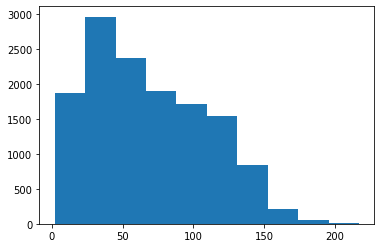

In [15]:
plt.hist(np.sort(sent_lengths))

In [105]:
# We see that 91.7% of our sentences have lengths less than 130 words
# So we arbitrarily pick this as our max sentence length
# NOTE: I tried longer sentence lengths, but the JupyterHub GPU crashes
max_idx = np.argmax(np.sort(sent_lengths) >130)
max_idx/13500

0.9168148148148149

In [18]:
# Set max words per sentence to 130
# Use this size for maxpooling layer
max_words_in_sent = 130 #max(sent_lengths)
print(max_words_in_sent)

130


In [19]:
# dictionary for word index (vocabulary)
word2idx = dict(zip(word_index, range(n_words+1)))
idx2word = dict(zip(range(n_words+1), word_index))

## <a id='b'>a. Generate X_train from cleaned data</a>

In [20]:
%%time
# convert to numeric using word2idx and add padding
X = []
for doc in df_cleaned:
    sents_in_doc = doc.split('newsenthere')
    
    mod_doc = []
    for sent in sents_in_doc:
        mod_sent=[]
        x_tokens = nltk.tokenize.WordPunctTokenizer().tokenize(sent)
        # Convert tokens in a sentence to index numbers
        for token in x_tokens:
            mod_sent.append(word2idx[token])
        mod_doc.append(mod_sent[:max_words_in_sent])
    X.append(pad_sequences(mod_doc, maxlen=max_words_in_sent, padding='post', value=0))

CPU times: user 21.7 s, sys: 182 ms, total: 21.9 s
Wall time: 21.9 s


In [21]:
# Generate the X_train
X_train = []
for doc in X:
    concat_doc = []
    for sent in doc:
        concat_doc.extend(sent)
    X_train.append(concat_doc)
len(X_train)

13500

In [22]:
# find the max_doc_len
doc_lengths = []
for doc in X_train:
    doc_lengths.append(len(doc))
max_doc_len = max(doc_lengths)
print("Max document length, by words: {}".format(max_doc_len))

Max document length, by words: 27820


In [23]:
# cap max senteces per doc to 110 sentences * 130 words per sent, cuz above max_length is too large
sents_per_doc =110
max_doc_len = sents_per_doc*max_words_in_sent
max_doc_len

14300

In [24]:
# Pad documents so that they are all the same number of sentences
X_tr_final = pad_sequences(X_train, maxlen=max_doc_len, padding='post', value=0)

In [25]:
X_tr_final.shape

(13500, 14300)

# <a id='2'>2. Pre-process Y_train labels</a>

In [1]:
# Due to batching error, only these pre-processed files work
# 2000 oracle iterations take 8 hours
files=["oracle_batch4.txt", 
      "oracle_batch10.txt", 
      "oracle_batch12.txt", 
    "oracle_batch14.txt",
     "oracle_batch15.txt", 
    "oracle_batch17.txt",
     "oracle_batch18.txt", 
    "oracle_batch19.txt"
      ]

In [2]:
# Builds unprocessed y_train (y_unproc) with a tuple of best sentence indices per document
# Also builds F1 Rouge-2 scores, calculated during pre-processing
# Borrowed from https://stackoverflow.com/questions/6633678/finding-words-after-keyword-in-python
y_unproc=[]
rouge_scores=[]

for file in files:
    f = open('./oracle/'+file, "r")
    for line in f:
        y_tup, split, rouge_score = line.partition('\t')
        rouge_score = rouge_score.strip('\n')
        y_unproc.append(y_tup)
        rouge_scores.append(rouge_score)

In [29]:
# find indices of N/A to drop later from x_train and y_train
null_y = []
for i in range(len(y_unproc)):
    if y_unproc[i] == 'None':
        null_y.append(i)

In [30]:
print("# of nulls: {}".format(len(null_y)))

# Drop nulls
X_tr_final = np.delete(X_tr_final, null_y, axis=0)
y_unproc = np.delete(y_unproc, null_y, axis=0)

# of nulls: 70


In [32]:
# set length of our y_train
y_len = len(y_unproc)
y_len

(13430,)

13430

In [33]:
# This generates the labels for each word in a sentence (binary 0 or 1, 1 being it is a chosen extracted summary sentence)

# initialize zeros in the correct y_train shape
y_full = np.zeros(shape=(y_len, sents_per_doc))
for i in range(y_len):
    if y_unproc[i] != 'None':
        y_p = y_unproc[i].strip('(),').split(', ')
        y_tpl = tuple(map(int, y_p))
        for j in y_tpl:
            if j < sents_per_doc:
                y_full[i][j] = 1.

In [34]:
y_full.shape

(13430, 110)

# <a id='3'>3. Small Model</a>

## <a id='3a'>a. Build embedding layer</a>
Get GloVE word embeddings

In [37]:
# https://nlp.stanford.edu/projects/glove/
## I used wikipedia 2014+ Gigaword
# Extract word vectors
embeddings_index = {}
f = open('glove.6B.50d.txt', encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

In [38]:
EMBEDDING_DIM = 50

In [39]:
# generate embedding matrix
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word2idx.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [40]:
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=max_doc_len,
                            trainable=False)

In [41]:
##Potentially use weighting to correct over imbalance between 0 and 1 y values

#def weighted_bce(y_true, y_pred):
#  weights = (y_true * 30.) + 1.
#  bce = K.binary_crossentropy(y_true, y_pred)
#  weighted_bce = K.mean(bce * weights)
#  return weighted_bce

## <a id='3b'>b. Build RNN-RNN model</a>

In [42]:
# architecture inspired by SummaRunner 
# https://github.com/hpzhao/SummaRuNNer/blob/master/models/RNN_RNN.py
n_units=50
optimizer = tf.keras.optimizers.Adam(clipvalue=1.0)
#"adam"
loss = 'binary_crossentropy'#weighted_bce
metrics = ["accuracy"]

seq_input = Input(shape=(max_doc_len,))
embedded_seq = embedding_layer(seq_input)

# Word-level GRU
x = Bidirectional(tf.keras.layers.GRU(n_units, return_sequences=True))(embedded_seq)

# MaxPool combines words into sentences
x = tf.keras.layers.MaxPool1D(pool_size = max_words_in_sent, padding='same')(x)

# Sentence-level GRU after maxpooling all words in a sentence
biGRU2 = Bidirectional(tf.keras.layers.GRU(n_units, return_sequences=True))(x)

# Classification at the sentence level
## Potential idea for next version: build more complex classifier layers or add attention layer
output = TimeDistributed(Dense(units=1, activation='sigmoid'))(biGRU2)


model = tf.keras.Model(inputs=seq_input, outputs=output) 

model.compile(optimizer=optimizer, loss=loss, metrics=metrics,)# sample_weight_mode = 'temporal')

print(model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 14300)]           0         
_________________________________________________________________
embedding (Embedding)        (None, 14300, 50)         4053450   
_________________________________________________________________
bidirectional (Bidirectional (None, 14300, 100)        30600     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 110, 100)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 110, 100)          45600     
_________________________________________________________________
time_distributed (TimeDistri (None, 110, 1)            101       
Total params: 4,129,751
Trainable params: 76,301
Non-trainable params: 4,053,450
______________________________________________

In [44]:
# the index at which to build validation set up to
val_size = int(X_tr_final.shape[0]*0.1)

# Shuffle indices randomly
indices = np.arange(X_tr_final.shape[0])
np.random.shuffle(indices)
X_tr_final = X_tr_final[indices]
y_full = y_full[indices]

# Generate Training and validation sets
x_train = X_tr_final[val_size:]
y_train = y_full[val_size:]
x_val = X_tr_final[:val_size]
y_val = y_full[:val_size]


In [45]:
%%time
# Train model
verbose = 1

#callback=tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=4)
history = model.fit(x_train, y_train, batch_size=64, epochs=5,#epochs, 
                    validation_data=(x_val, y_val), verbose=verbose,
                    shuffle=True,
                   )

Train on 12087 samples, validate on 1343 samples
Epoch 1/5
12087/12087 [==============================] - 540s 45ms/sample - loss: 0.1525 - accuracy: 0.9652 - val_loss: 0.1068 - val_accuracy: 0.9695
Epoch 2/5
12087/12087 [==============================] - 520s 43ms/sample - loss: 0.1045 - accuracy: 0.9690 - val_loss: 0.1029 - val_accuracy: 0.9694
Epoch 3/5
12087/12087 [==============================] - 519s 43ms/sample - loss: 0.1028 - accuracy: 0.9690 - val_loss: 0.1018 - val_accuracy: 0.9694
Epoch 4/5
12087/12087 [==============================] - 519s 43ms/sample - loss: 0.1020 - accuracy: 0.9690 - val_loss: 0.1011 - val_accuracy: 0.9695
Epoch 5/5
12087/12087 [==============================] - 520s 43ms/sample - loss: 0.1012 - accuracy: 0.9690 - val_loss: 0.1005 - val_accuracy: 0.9694
CPU times: user 33min 22s, sys: 9min 29s, total: 42min 52s
Wall time: 43min 40s


In [46]:
## Save model
#model.save_weights("{}.h5".format('extract_model_v3'))

In [ ]:
model.load_weights("extract_model_v3.h5")

# <a id='4'>4. Predict Summary and Score Summary</a>

In [47]:
# Generate probability predictions for each sentence in each document
y_val_prob = model.predict(x_val)

In [91]:
# Following the SummaRunner article, we decide on our best sentences, NOT by p>0.5,
# because our positive true labels are too sparse. Instead, pick 5 largest probabilities
# per document for our 5-sentence summaries.
val_best_sents = []
for i in range(len(y_val_prob)):
    # Get first 5 sentence indices with largest probabilities
    best = np.argsort(y_val_prob[i].reshape(-1))[::-1][0:5]
    val_best_sents.append(best)

In [49]:
# Builds document and loads it for scoring
from Document import Document

def load_data(src_file, tgt_file):
    docs = []
    for src_line, tgt_line in zip(src_file, tgt_file):
        src_line = src_line.strip()
        tgt_line = tgt_line.strip()
        #if src_line == "" or tgt_line == "":
        #    docs.append(None)
        #    continue
        src_sents = src_line.split('##SENT##')
        tgt_sents = tgt_line.strip().split('##SENT##')
        docs.append(Document(src_sents, tgt_sents))
    return docs

In [84]:
df.drop(null_y).shape

(13430, 5)

In [94]:
# Drop nulls from original imported DF and then select the validation indices
val_df = df.drop(null_y).iloc[indices][:val_size]
docs = load_data(val_df['token_ops'], val_df['token_heads'])

## <a id='4b'>b. Find Rouge Scores</a>

In [95]:
from PyRouge.Rouge.Rouge import Rouge

rouge = Rouge(use_ngram_buf=True)

### Model-generated summary's Rouge-2 F1 score

In [96]:
scores_pred=[]
for comb, document in zip(val_best_sents, docs):
    c_string=[]
    for idx in comb:
        if idx < document.doc_len:
            c_string.append(document.doc_sents[idx])
    score = rouge.compute_rouge([document.summary_sents], [c_string])
    scores_pred.append(score)

In [ ]:
rouge1_f_scores_pred =[]
for score in scores_pred:
    f_score = score['rouge-1']['f'][0]
    rouge1_f_scores_pred.append(f_score)

# Find average rouge score for all documents in validation set
model_score = sum(rouge1_f_scores_pred)/len(rouge1_f_scores_pred)

print("Model's Rouge-1 F1 Score: {}".format(model_score))

In [120]:
rouge2_f_scores_pred =[]
for score in scores_pred:
    f_score = score['rouge-2']['f'][0]
    rouge2_f_scores_pred.append(f_score)

# Find average rouge score for all documents in validation set
model_score = sum(rouge2_f_scores_pred)/len(rouge2_f_scores_pred)

print("Model's Rouge-2 F1 Score: {}".format(model_score))

Model's Rouge-2 F1 Score: 0.14429496859829427


### Actual Rouge-2 F1 Score based off of our "true" y labels

In [98]:
rouge_true = pd.Series(rouge_scores).iloc[indices][:val_size]

In [99]:
## see if Rouge-2 score averages match what we outputted in preprocessing
rouge_pre_proc = []
for i in rouge_true:
    rouge_pre_proc.append(np.float(i))

In [121]:
true_score = sum(rouge_pre_proc)/len(rouge_pre_proc)

print("True label's Rouge-2 F1 Score: {}".format(true_score))

True label's Rouge-2 F1 Score: 0.25884311878219274


In [ ]:
# Use this function to make code mor legible later
def score_one(comb, document):
    c_string=[]
    for idx in comb:
        if idx < document.doc_len:
            c_string.append(document.doc_sents[idx])
    score = rouge.compute_rouge([document.summary_sents], [c_string])
    return score

In [ ]:
score_one(y_true_combos[0], docs2[0])

### True average rouge score for our entire training set 
Based off true y labels

In [71]:
#make sure to drop null, or y's will not align
docs2 = load_data(df['token_ops'].drop(null_y), df['token_heads'].drop(null_y))

In [72]:
# Check that our document # and # of y labels match
display(len(docs2))
display(len(y_unproc))

13430

In [61]:
y_true_combos = []
for doc in y_unproc:
    if doc != 'None':
        y_p = doc.strip('(),').split(', ')
        y_tpl = tuple(map(int, y_p))
        y_true_combos.append(y_tpl)
    else:
        y_true_combos.append((9999999,))

In [73]:
scores_true=[]
for comb, document in zip(y_true_combos, docs2):
    c_string=[]
    for idx in comb:
        if idx < document.doc_len:
            c_string.append(document.doc_sents[idx])
    score = rouge.compute_rouge([document.summary_sents], [c_string])
    scores_true.append(score)

In [106]:
rouge2_f_scores =[]
for score in scores_true:
    f_score = score['rouge-2']['f'][0]
    rouge2_f_scores.append(f_score)
    
avg_true_score = sum(rouge2_f_scores)/len(rouge2_f_scores)
print("The average true score for entire dataset: {}".format(avg_true_score))

The average true score for entire dataset: 0.25657885279697557
